# Pneumonia Detection Using Multimodal Deep Learning

This project implements a multimodal deep learning model for pneumonia detection using chest X-ray images from a Kaggle dataset and synthetic symptom text data. It uses ResNet18 for image processing, DistilBERT for text processing, and a fusion model to combine both modalities.

**Requirements**: Google Colab with A100 GPU, Kaggle API key.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install -q kaggle torch torchvision transformers pandas numpy scikit-learn matplotlib seaborn streamlit
!pip install -q tensorflow torchmetrics

# Import libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 136.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Data Preparation

Download the chest X-ray dataset from Kaggle and generate synthetic symptom text data for each image. All data is stored in `/content/drive/MyDrive/pneumonia_detection/`.

In [ ]:
# Set up Kaggle API and download dataset
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Define project directory in Google Drive
project_dir = '/content/drive/MyDrive/pneumonia_detection'
os.makedirs(project_dir, exist_ok=True)

# Download and unzip dataset to project directory
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p {project_dir}
!unzip -q {project_dir}/chest-xray-pneumonia.zip -d {project_dir}

# Define paths
data_dir = os.path.join(project_dir, 'chest_xray')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Generate synthetic symptom text data
symptoms = [
    "fever", "cough", "chest pain", "shortness of breath", "fatigue",
    "chills", "sweating", "headache", "loss of appetite", "muscle pain"
]
def generate_symptom_text(label, num_symptoms=3):
    if label == 'PNEUMONIA':
        selected = np.random.choice(symptoms, size=num_symptoms, replace=False)
        return f"Patient reports {', '.join(selected)}."
    else:
        return "Patient reports no significant symptoms."

# Create symptom dataset
image_paths = []
labels = []
symptom_texts = []
for folder in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(train_dir, folder)
    for img_name in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_name))
        labels.append(1 if folder == 'PNEUMONIA' else 0)
        symptom_texts.append(generate_symptom_text(folder))
df = pd.DataFrame({'image_path': image_paths, 'label': labels, 'symptoms': symptom_texts})

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


## Dataset and DataLoader

Create a custom dataset to handle both image and text data, and set up data loaders.

In [ ]:
# Define custom dataset
class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        symptom_text = self.df.iloc[idx]['symptoms']
        label = self.df.iloc[idx]['label']

        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Tokenize text
        encoding = self.tokenizer(symptom_text, padding='max_length', truncation=True, max_length=50, return_tensors='pt')

        return {
            'image': img,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_dataset = MultimodalDataset(train_df, tokenizer, transform)
val_dataset = MultimodalDataset(val_df, tokenizer, transform)
test_dataset = MultimodalDataset(test_df, tokenizer, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Model Definition
Define the ResNet18, DistilBERT, and multimodal fusion models.

In [ ]:
# Define ResNet18 model
class ResNet18Model(nn.Module):
    def __init__(self):
        super(ResNet18Model, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

    def forward(self, x):
        return self.resnet(x)

# Define DistilBERT model
class DistilBERTModel(nn.Module):
    def __init__(self):
        super(DistilBERTModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.fc = nn.Linear(768, 128)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        return self.fc(pooled)

# Define multimodal fusion model
class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.image_model = ResNet18Model()
        self.text_model = DistilBERTModel()
        self.fusion = nn.Sequential(
            nn.Linear(128 + 128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, images, input_ids, attention_mask):
        img_features = self.image_model(images)
        text_features = self.text_model(input_ids, attention_mask)
        combined = torch.cat((img_features, text_features), dim=1)
        return self.fusion(combined)

## Training
Train the multimodal model for 5 epochs and track loss and accuracy.

In [ ]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in train_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.2MB/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.1911, Train Acc: 0.9280, Val Loss: 0.0944, Val Acc: 0.9680
Epoch 2/5, Train Loss: 0.1316, Train Acc: 0.9548, Val Loss: 0.0534, Val Acc: 0.9885
Epoch 3/5, Train Loss: 0.0896, Train Acc: 0.9704, Val Loss: 0.0738, Val Acc: 0.9719
Epoch 4/5, Train Loss: 0.0819, Train Acc: 0.9710, Val Loss: 0.1086, Val Acc: 0.9629
Epoch 5/5, Train Loss: 0.0709, Train Acc: 0.9789, Val Loss: 0.0558, Val Acc: 0.9795


## Evaluation
Evaluate the model on the test set and save the trained model in the Google Drive folder.

In [ ]:
# Evaluate on test set
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images, input_ids, attention_mask).squeeze()
        preds = (outputs > 0.5).float()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')
print(f'Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

# Save model
model_path = os.path.join(project_dir, 'multimodal_pneumonia_model.pth')
torch.save(model.state_dict(), model_path)

Test Accuracy: 0.9783, Precision: 0.9947, Recall: 0.9759, F1: 0.9853


## Visualization
Plot training and validation loss and accuracy curves, saving the plot in the Google Drive folder.

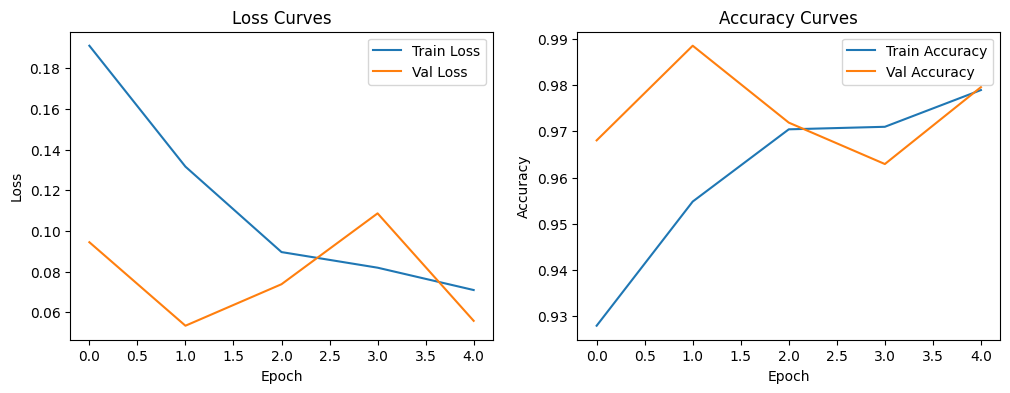

In [ ]:
# Plot training metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.savefig(os.path.join(project_dir, 'training_metrics.png'))

# Live Demo

Please follow the instructions to get the predictions


Upload a chest X-ray image (.jpg, .jpeg, or .png):


Saving person1674_virus_2890.jpeg to person1674_virus_2890.jpeg


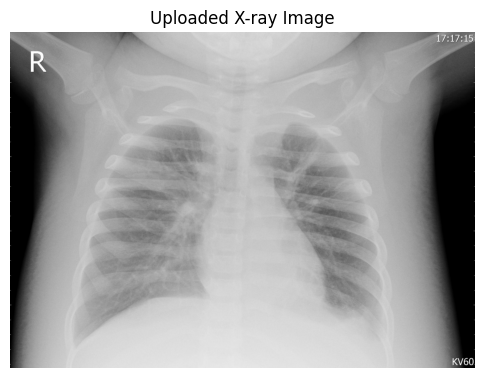

Select symptoms by entering numbers (e.g., '1 3 5' for fever, chest pain, chills). Leave blank for no symptoms:
1. fever
2. cough
3. chest pain
4. shortness of breath
5. fatigue
6. chills
7. sweating
8. headache
9. loss of appetite
10. muscle pain
Enter symptom numbers (space-separated): 1 3 5

Symptoms: Patient reports fever, chest pain, fatigue.
Prediction: Pneumonia
Confidence: 100.00%


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from transformers import DistilBertTokenizer, DistilBertModel
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
import os
from google.colab import files
import matplotlib.pyplot as plt

# Define models (same as in training)
class ResNet18Model(nn.Module):
    def __init__(self):
        super(ResNet18Model, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

    def forward(self, x):
        return self.resnet(x)

class DistilBERTModel(nn.Module):
    def __init__(self):
        super(DistilBERTModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.fc = nn.Linear(768, 128)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        return self.fc(pooled)

class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.image_model = ResNet18Model()
        self.text_model = DistilBERTModel()
        self.fusion = nn.Sequential(
            nn.Linear(128 + 128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, images, input_ids, attention_mask):
        img_features = self.image_model(images)
        text_features = self.text_model(input_ids, attention_mask)
        combined = torch.cat((img_features, text_features), dim=1)
        return self.fusion(combined)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalModel().to(device)
model_path = os.path.join(project_dir, 'multimodal_pneumonia_model.pth')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}. Please run the evaluation cell to save the model.")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Upload image
print("Upload a chest X-ray image (.jpg, .jpeg, or .png):")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded. Please upload an image.")
image_name = list(uploaded.keys())[0]
image = Image.open(image_name).convert('RGB')

# Display uploaded image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title('Uploaded X-ray Image')
plt.show()

# Process image
image_tensor = transform(image).unsqueeze(0).to(device)

# Get symptoms input
symptoms = [
    "fever", "cough", "chest pain", "shortness of breath", "fatigue",
    "chills", "sweating", "headache", "loss of appetite", "muscle pain"
]
print("Select symptoms by entering numbers (e.g., '1 3 5' for fever, chest pain, chills). Leave blank for no symptoms:")
for i, symptom in enumerate(symptoms, 1):
    print(f"{i}. {symptom}")
selected_indices = input("Enter symptom numbers (space-separated): ").strip()

# Process symptoms
if selected_indices:
    try:
        indices = [int(i) - 1 for i in selected_indices.split() if i.isdigit() and 1 <= int(i) <= len(symptoms)]
        selected_symptoms = [symptoms[i] for i in indices]
        symptom_text = f"Patient reports {', '.join(selected_symptoms)}."
    except (ValueError, IndexError):
        raise ValueError("Invalid input. Please enter valid numbers corresponding to symptoms.")
else:
    selected_symptoms = []
    symptom_text = "Patient reports no significant symptoms."

# Process text
encoding = tokenizer(symptom_text, padding='max_length', truncation=True, max_length=50, return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

# Predict
with torch.no_grad():
    output = model(image_tensor, input_ids, attention_mask).squeeze()
    prediction = 'Pneumonia' if output > 0.5 else 'Normal'
    confidence = output.item() if output > 0.5 else 1 - output.item()

# Display results
print(f"\nSymptoms: {symptom_text}")
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.2%}")